In [1]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

In [2]:
texts = [
    "Win cash", "free money", "free cash","cash money",
    "Thank you", "Best wishes","Cheers mate"
]
spam = [1,1,1,1,0,0,0]

vec = CountVectorizer()
dfmat = vec.fit_transform(texts)
pd.DataFrame(dfmat.todense(),columns=vec.get_feature_names_out(), index=texts)

,best,cash,cheers,free,mate,money,thank,win,wishes,you
Win cash,0,1,0,0,0,0,0,1,0,0
free money,0,0,0,1,0,1,0,0,0,0
free cash,0,1,0,1,0,0,0,0,0,0
cash money,0,1,0,0,0,1,0,0,0,0
Thank you,0,0,0,0,0,0,1,0,0,1
Best wishes,1,0,0,0,0,0,0,0,1,0
Cheers mate,0,0,1,0,1,0,0,0,0,0


In [3]:
vec.get_feature_names_out()

array(['best', 'cash', 'cheers', 'free', 'mate', 'money', 'thank', 'win',
       'wishes', 'you'], dtype=object)

In [4]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(dfmat, spam)

print(clf.intercept_)

coefs = dict(zip(vec.get_feature_names_out(),clf.coef_.ravel()))

coefs

[-0.01988335]


{'best': -0.33436349993422576,
 'cash': 0.7307870789854916,
 'cheers': -0.33436349993422576,
 'free': 0.5015353821727061,
 'mate': -0.33436349993422576,
 'money': 0.5015353821727061,
 'thank': -0.33436349993422576,
 'win': 0.2722836853599208,
 'wishes': -0.33436349993422576,
 'you': -0.33436349993422576}

In [5]:
from scipy.stats import logistic

logistic.cdf(clf.intercept_ + coefs["cash"])

array([0.67060082])

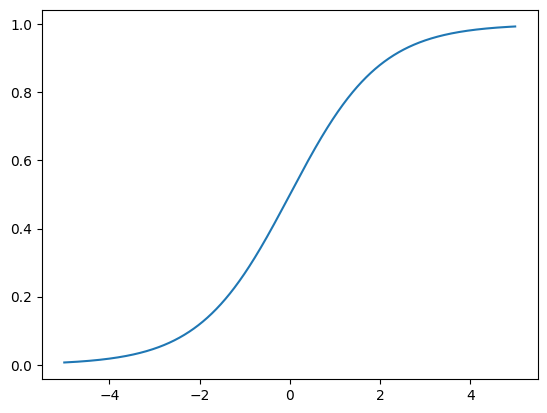

In [6]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(1000) * 0.01 - 5

plt.plot(x,logistic.cdf(x))

In [7]:
clf.predict_proba(vec.transform(["cash please"]))

array([[0.32939918, 0.67060082]])

In [8]:
import pandas as pd
df = pd.read_csv("../datasets/uk_manifestos.csv")
df.head()

,text,cmp_code,eu_code,party
0,This election is about the crisis of living st...,503.0,NaN,Labour
1,and the climate and environmental emergency.,501.0,NaN,Labour
2,"Whether we are ready or not, we stand on the b...",501.0,NaN,Labour
3,We must confront this change while dealing wit...,503.0,NaN,Labour
4,Labour led the UK Parliament in declaring a cl...,501.0,NaN,Labour


In [9]:
df[df["cmp_code"]==501]

,text,cmp_code,eu_code,party
1,and the climate and environmental emergency.,501.0,NaN,Labour
2,"Whether we are ready or not, we stand on the b...",501.0,NaN,Labour
4,Labour led the UK Parliament in declaring a cl...,501.0,NaN,Labour
5,The next Labour government will lead the world...,501.0,NaN,Labour
6,The climate crisis ties us all into a common f...,501.0,NaN,Labour
...,...,...,...,...
5096,and the planet which sustains us.,501.0,NaN,Greens
5101,"and the Green New Deal, and deliver ongoing ec...",501.0,NaN,Greens
5198,The funds saved from cancelling Trident will b...,501.0,NaN,Greens
5199,and finance to help countries deal with the Cl...,501.0,NaN,Greens


In [10]:
import numpy as np
df["climate"] = np.where(df["cmp_code"]==501,1,0)
df.head()

,text,cmp_code,eu_code,party,climate
0,This election is about the crisis of living st...,503.0,NaN,Labour,0
1,and the climate and environmental emergency.,501.0,NaN,Labour,1
2,"Whether we are ready or not, we stand on the b...",501.0,NaN,Labour,1
3,We must confront this change while dealing wit...,503.0,NaN,Labour,0
4,Labour led the UK Parliament in declaring a cl...,501.0,NaN,Labour,1


0.10248091603053436

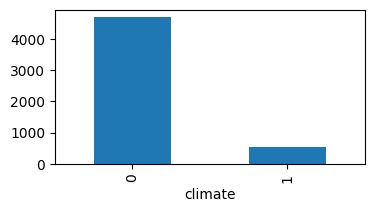

In [11]:
fig, ax = plt.subplots(figsize=(4,2))
df.groupby(["climate"])["text"].count().plot.bar(ax=ax)
df["climate"].sum() / df.shape[0]

<Axes: xlabel='climate,party'>

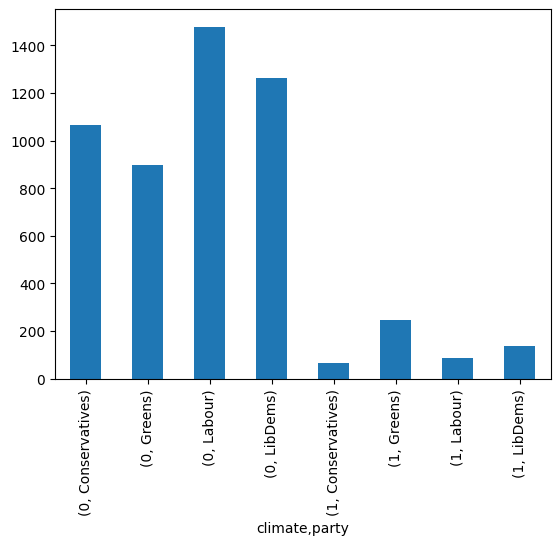

In [12]:
df.groupby(["climate","party"])["text"].count().plot.bar()

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


clf = Pipeline(
    steps=[
        ("vect", TfidfVectorizer()),
        ("clf", SVC(probability=True, class_weight="balanced")),
    ]
)


In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.text, df.climate, test_size=0.2, random_state=42)

clf.fit(X_train, y_train)

Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf', SVC(class_weight='balanced', probability=True))])

In [15]:
clf.predict_proba([
    "We will not raise taxes",
    "We will protect our natural resources"
])

array([[0.98693629, 0.01306371],
       [0.14821774, 0.85178226]])

In [16]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score

y_pred = clf.predict_proba(X_test)

roc_auc = roc_auc_score(y_test, y_pred[:,1])
recall = recall_score(y_test, y_pred[:,1].round())
prec = precision_score(y_test, y_pred[:,1].round())
acc = accuracy_score(y_test, y_pred[:,1].round())
f1 = f1_score(y_test, y_pred[:,1].round())

print(f"ROC-AUC: {roc_auc:.1%}, Accuracy: {acc:.1%}, Precision: {prec:.1%}, recall: {recall:.1%}, F1 score: {f1:.1%}")

ROC-AUC: 93.8%, Accuracy: 92.5%, Precision: 80.3%, recall: 48.8%, F1 score: 60.7%


In [17]:
from sklearn.model_selection import GridSearchCV

parameters = [
    {
        'vect__max_df': (0.5,0.8),
        'vect__min_df': (5, 15),
        'vect__ngram_range': ((1, 1), (1, 2)),  
        'clf__kernel': ['linear'], 
        'clf__C': [10, 1, 1e2, 1e3]
    }
]

grid_search = GridSearchCV(clf, parameters, scoring="f1", n_jobs=4, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                       ('clf',
                                        SVC(class_weight='balanced',
                                            probability=True))]),
             n_jobs=4,
             param_grid=[{'clf__C': [10, 1, 100.0, 1000.0],
                          'clf__kernel': ['linear'], 'vect__max_df': (0.5, 0.8),
                          'vect__min_df': (5, 15),
                          'vect__ngram_range': ((1, 1), (1, 2))}],
             scoring='f1', verbose=1)

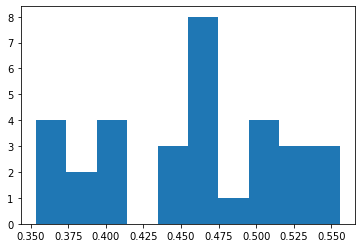

In [18]:
import matplotlib.pyplot as plt
res = pd.DataFrame(grid_search.cv_results_).sort_values("rank_test_score",ascending=True)
plt.hist(res["mean_test_score"])
plt.savefig("plots/hyperparam.png")

In [19]:
y_pred = grid_search.predict_proba(X_test)

roc_auc = roc_auc_score(y_test, y_pred[:,1])
recall = recall_score(y_test, y_pred[:,1].round())
prec = precision_score(y_test, y_pred[:,1].round())
acc = accuracy_score(y_test, y_pred[:,1].round())
f1 = f1_score(y_test, y_pred[:,1].round())

print(f"ROC-AUC: {roc_auc:.1%}, Accuracy: {acc:.1%}, Precision: {prec:.1%}, recall: {recall:.1%}, F1 score: {f1:.1%}")

ROC-AUC: 91.0%, Accuracy: 91.6%, Precision: 76.8%, recall: 42.4%, F1 score: 54.6%


In [20]:
grid_search.best_estimator_

Pipeline(steps=[('vect',
                 TfidfVectorizer(max_df=0.5, min_df=5, ngram_range=(1, 2))),
                ('clf',
                 SVC(C=1, class_weight='balanced', kernel='linear',
                     probability=True))])

In [21]:
grid_search = GridSearchCV(clf, parameters, scoring="roc_auc", n_jobs=4, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                       ('clf',
                                        SVC(class_weight='balanced',
                                            probability=True))]),
             n_jobs=4,
             param_grid=[{'clf__C': [10, 1, 100.0, 1000.0],
                          'clf__kernel': ['linear'], 'vect__max_df': (0.5, 0.8),
                          'vect__min_df': (5, 15),
                          'vect__ngram_range': ((1, 1), (1, 2))}],
             scoring='roc_auc', verbose=1)

In [22]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

res = []

from sklearn.model_selection import KFold
kf = KFold(n_splits=2, random_state=None, shuffle=False)
k = 0
for train_index, test_index in kf.split(X_train):
    clf = grid_search.best_estimator_
    clf.fit(X_train[train_index], y_train[train_index])
    y_pred_k = clf.predict_proba(X_train[test_index])
    for t in np.linspace(0.1, 0.9, 50):
        y_pred_bin = np.where(y_pred_k[:,1]>t,1,0)
        res.append({
            "t": t, 
            "f1": f1_score(y_train[test_index], y_pred_bin),
            "k": k
        })
    k+=1
    
res = pd.DataFrame(res)

In [23]:
optimal_t = res.groupby("t")["f1"].mean().sort_values(ascending=False).index[0]

print(optimal_t)

y_pred_bin = np.where(y_pred[:,1]>optimal_t,1,0)
recall = recall_score(y_test, y_pred_bin)
prec = precision_score(y_test, y_pred_bin)
acc = accuracy_score(y_test, y_pred_bin)
f1 = f1_score(y_test, y_pred_bin)

print(f"Accuracy: {acc:.1%}, Precision: {prec:.1%}, recall: {recall:.1%}, F1 score: {f1:.1%}")

0.2306122448979592
Accuracy: 91.6%, Precision: 63.9%, recall: 68.0%, F1 score: 65.9%


In [24]:
grid_search.predict_proba(["We will put climate protection at the heart of our agenda"])

array([[0.32928257, 0.67071743]])

A Classifier for predicting EU

In [16]:
df[df["cmp_code"].isin([108, 110])]

,text,cmp_code,eu_code,party,climate
626,Our security co-operation arrangements with EU...,108.0,NaN,Labour,0
627,If the British people confirm their decision t...,108.0,NaN,Labour,0
1317,Three years on from the 2016 EU referendum we ...,108.0,NaN,Labour,0
1319,and in Wales the Welsh Labour government will ...,108.0,NaN,Labour,0
1368,Continued participation in EU agencies and fun...,108.0,NaN,Labour,0
...,...,...,...,...,...
4560,"EU policies hold the key to this, including an...",108.0,NaN,Greens,0
4561,and fiscal transfers via the Euro.,108.0,NaN,Greens,0
4931,As a member of the EU we will press for a revi...,108.0,NaN,Greens,0
5154,We will advocate public country-by-country rep...,108.0,NaN,Greens,0


In [17]:
df["eu"] = np.where(df["cmp_code"].isin([108, 110]),1,0)
df.head()

,text,cmp_code,eu_code,party,climate,eu
0,This election is about the crisis of living st...,503.0,NaN,Labour,0,0
1,and the climate and environmental emergency.,501.0,NaN,Labour,1,0
2,"Whether we are ready or not, we stand on the b...",501.0,NaN,Labour,1,0
3,We must confront this change while dealing wit...,503.0,NaN,Labour,0,0
4,Labour led the UK Parliament in declaring a cl...,501.0,NaN,Labour,1,0


<Axes: xlabel='eu,party'>

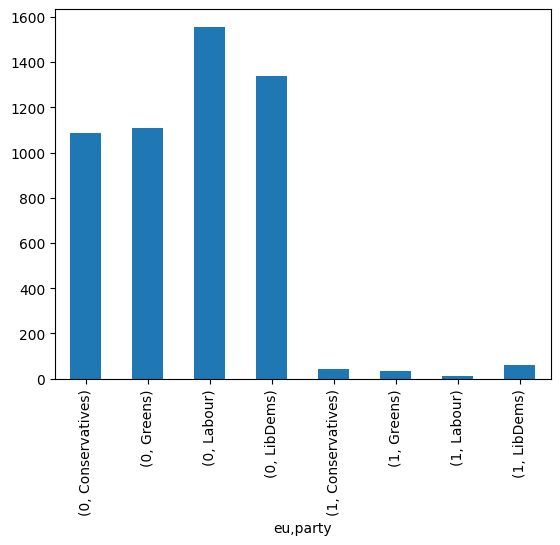

In [18]:
df.groupby(["eu","party"])["text"].count().plot.bar()

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


clf = Pipeline(
    steps=[
        ("vect", TfidfVectorizer()),
        ("clf", SVC(probability=True, class_weight="balanced")),
    ]
)

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.text, df.eu, test_size=0.2, random_state=42)

clf.fit(X_train, y_train)

Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf', SVC(class_weight='balanced', probability=True))])

In [21]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score

y_pred = clf.predict_proba(X_test)

roc_auc = roc_auc_score(y_test, y_pred[:,1])
recall = recall_score(y_test, y_pred[:,1].round())
prec = precision_score(y_test, y_pred[:,1].round())
acc = accuracy_score(y_test, y_pred[:,1].round())
f1 = f1_score(y_test, y_pred[:,1].round())

print(f"ROC-AUC: {roc_auc:.1%}, Accuracy: {acc:.1%}, Precision: {prec:.1%}, recall: {recall:.1%}, F1 score: {f1:.1%}")

ROC-AUC: 98.8%, Accuracy: 98.5%, Precision: 73.7%, recall: 56.0%, F1 score: 63.6%
